## Grainsize distribution and Pandas

This notebook is about finding the grainsize distribution of tephra in a set of outcrops by importing the data into the notebook via pandas. Your objectives in checking out this notebook might be:

1. learn more about handling data in pandas, especially when the dataframe is not in a simple format, but rather represents a more complex data set than, say, xyz
2. practice with cumulative distribution functions, in ths case finding the Inman parameters of median grainsize and sorting from calculating the percentiles of the distribution of tephra particle sizes in each outcrop
3. learn about interpolation, in this case a linear interpolation uses binned data (seive sizes) to find percentiles ($M_{\phi}$, $\phi_{16}$, and $\phi_{84}$).
4. Maybe learn about grainsize variation in volcanic eruptions!

The data set is tephra granulometric analyses from a series of tephrastratigraphic sections of the 1992 eruption of Cerro Negro volcano (Nicaragua). The data are collected at varying distances from the volcano, and it is expected that the grainsize distribution changes with distance. 


### Metadata

The data were collected after the 1992 eruption to learn more about eruption source parameters (ESPs). The data file consists of 21 columns these are:

1. Sample ID - simply a number corresponding to a specific sample location. In some cases more than one sample is collected at a specific location, so the sample ID is repeated in the data set. One location has one sample ID.

2. Layer - The 1992 eruption occurred in 2 phases and these two phases deposited 2 layers which can be distinguished in some stratigraphic sections, but not in others. The layers are "a" and "b". Layer $a$ is stratigraphically below layer $b$. The first phase of the eruption deposited layer $a$, then there was a pause, followed by a second eruption that deposited layer $b$. In some sections the layers are not distinguished. For example, far from the volcano it is difficult to know if the one layer observed is $a$ or $b$ or a combination. These layers are designated layer "m", for mixed. But they are probably not actually mixed, they are just not distinguished. Think of $m$ as a combined measurement.

3. easting - this is the UTM easting location of the Sample ID location (m)

4. northing - this is the UTM northing of the Sample ID location (m)

5. total(kg/m2) - this is the mass loading in kg/m2 dry deposit observed at each Sample ID location and for each layer ($a$,$b$, or $m$). Mass loading can be converted to thickness since the deposit density is 1000 kg/m3.

6-21. This is the mass loading by grainsize, from phi class equal to or coarser than $-4 \phi$ (coarse particles) to fine particles $>3 \phi$, seived in $1/2 \phi$ increments. There are a total of 16 $\phi$ classes. If one adds the phi size mass loadings together, one should get the total (column 5). This can be used as a check on the data quality.

So the column headers are specific observations, the rows are analyses associated with each sample location. The index goes from zero to the total number of observations. Sample ID is not used as an index because often two samples are collected at each location.

In [5]:
import pandas as pd


### Step 1. Import the data into the notebook

The data file is a flat file with elements separated by commas (csv). The first row is the header, so a simple command imports the data into a pandas dataframe, called "cn", for Cerro Negro.

Note on the header: this pandas file is read literally. There are no spaces between the commas and the strings in the header. If their were, column names would include the space, which would be confusing in the code to manipulate the columns by header.

The following notebook cell reads in all the data, and the user changes which stratigraphic section and layer is analyzed for grainsize distribution from the dataframe. The sample to analyze is selected using the index.

Change the variable my_index to change which section is analyzed.

A single row is printed, showing the data corresponding to the index (the sample location and layer) selected by the user.

In [25]:
#Read in the dataframe
#specific the row
#print the row data

cn = pd.read_csv('./cerro_negro.dat')

#change the index to chose the grainsize distribution
# for a different sample
my_index = 1

#print the data for this sample
cn.loc[[my_index]]



,sample,layer,easting,northing,total(kg/m2),<=-4phi,<=-3.5phi,<=-3phi,<=-2.5phi,<=-2phi,...,<=-1phi,<=-0.5phi,<=0phi,<=0.5phi,<=1phi,<=1.5phi,<=2phi,<=2.5phi,<=3phi,>3phi
1,1,b,526774,1381087,184.96,0.0,0.0,0.85,5.25,11.39,...,33.84,44.73,31.5,22.2,10.47,3.77,0.75,0.1,0.02,0.0


### Step 2

For the selected row, calculate the median, $M_{\phi}$ and the sorting.

The cell to implement this step includes:

1. a function (interpolate_inman). This function finds the values of the normalized cdf above and below the inman parameter (e.g., median - 0.5) based on the index and linearly interpolates between these two values to find the $\phi$ size corresponding to the parameter

This function works as follows. 

    a. input info about the distribution (phi class and cumulative distribution as a function of phi class). In addition the percentile is specified, these are either 16th, 50th, and 84th percentile. The phi class that is less than the percentile is passed to the function.
    
    b. With this information find the the phi classes and their cumulative mass fractions immediate above and below the percentile.
    
    c. interpolate to the percentile. For example:
    
$$  \phi_{50} = \frac{(y_1-y_o)}{(x_1-x_o)} \times (x-x_o) + 0.5$$
where: $y_1$ is the cumulative mass fraction in the $\phi$ class, $x_1$, immediately above the 50th percentile, $y_o$ is the cumulative mass fraction in the $\phi$ class, $x_1$, immediately below the 50th percentile. Other percentile are calculated in hte same way (changing 0.5 to, say, 0.16).

    d. The cumulative mass fraction at that percentile is returned.

2. Variables are assigned for the sample id, layer, easting, northing and total mass

3. The grainsize data for this row are turned into a list.

4. The list is used to calculate the cumulative distribution function for this grainsize data

5. The median and sorting are found from the CDF of grainsize using the interpolate_inman function

6. The results are printed.

There is some error handling built in, in case the distribution is incomplete, like if the $\phi_{84}$ corresponds to the last bin, but errors are not caught exhaustively.

In [26]:
# this function is an interpolation method
# find the point less than the inman threshold (e.g., median)
# find the point greater than teh inman threshold
#interpolate to find the inman parameter (e.g., median)
def interpolate_inman(phi, cum_mass_frac, inman_param, index):
    y1 = phi[index]
    yo = phi[index+1]
    x1 = cum_mass_frac[index]
    xo = cum_mass_frac[index+1]
    x = inman_param #median
    y = (y1-yo)/(x1-xo) * (x-xo) + yo
    return y



#get information from the row
sample_id = cn.iloc[my_index]["sample"]
sample_layer = cn.iloc[my_index]['layer']


sample_easting = cn.iloc[my_index]["easting"]
sample_northing = cn.iloc[my_index]["northing"]

sample_total_mass = cn.iloc[my_index]['total(kg/m2)']

#inman parameter thresholds
inman_med = 0.5  #median
inman_low = 0.16 #16th percentile
inman_hi = 0.84  #84th percentile

#extract the grainsize data for my_index
#part of one row of the dataframe
#the grainsize data are in columns 5 to 21
sample1 = cn.iloc[my_index:my_index+1, 5:21]

series = sample1.squeeze()
gs = series.tolist() #list of grainsizes for the sample

#minphi is the coarsest grainsize class
#num_phi is the number of grainsize classes
minphi = -4
num_classes = 16

#for these grainsize data, calculate
#cumulative mass fraction as a function
# of grainsize class
phi =[]
cum_mass_frac = []
ct = minphi #smallest phi size in this dataset
cumulative_mass = 0

#initialize variables for inman calculation
min_low_index = 0
min_hi_index = 0
min_median_index = 0
my_phi84 = 0
my_phi16 =0
my_median = 0
my_total_mass = sum(gs)

for x in range (0,num_classes): #goes from -4 phi to >3 phi in 1/2 phi increment
    ct = minphi + x/2
    phi.append(ct)

    cumulative_mass = cumulative_mass+gs[x]/my_total_mass
    cum_mass_frac.append(cumulative_mass)
    
    if (cumulative_mass < inman_med):
        min_median_index = x
        
    if (cumulative_mass < inman_low):
        min_low_index = x
        
    if (cumulative_mass < inman_hi):
        min_hi_index = x

my_median = interpolate_inman(phi, 
                              cum_mass_frac, 
                              inman_med, 
                              min_median_index)

#the gs analysis cuts off without
#getting enough fraction of the fines

if (min_hi_index == len(phi)-1) or (min_low_index == 0):
    print("cannot calculate sorting")
    my_sorting = "out of range"
else:
    my_phi84 = interpolate_inman(phi, cum_mass_frac, inman_hi, min_hi_index)
    my_phi16 = interpolate_inman(phi,cum_mass_frac, inman_low, min_low_index)
    my_sorting = my_phi84-my_phi16

print("sample id = ", sample_id, sample_layer)
print("sample location = ", sample_easting, " E,", sample_northing, " N")
print("total mass loading = ", sample_total_mass, "(kg/m2) ")

print("check - do grainsizes sum to total mass loading?: ", sum(gs))

print("median grainsize = ", my_median, "phi")
print ("sorting = ", my_sorting, "phi")

sample id =  1  b
sample location =  526774  E, 1381087  N
total mass loading =  184.96 (kg/m2) 
check - do grainsizes sum to total mass loading?:  184.97
median grainsize =  -0.7646434160518669 phi
sorting =  1.8726323786473036 phi


### Step 3:

Plot the results. The CDF for the index is plotted and the median and lower and upper bounds of the sorting are plotted (different colored circles).

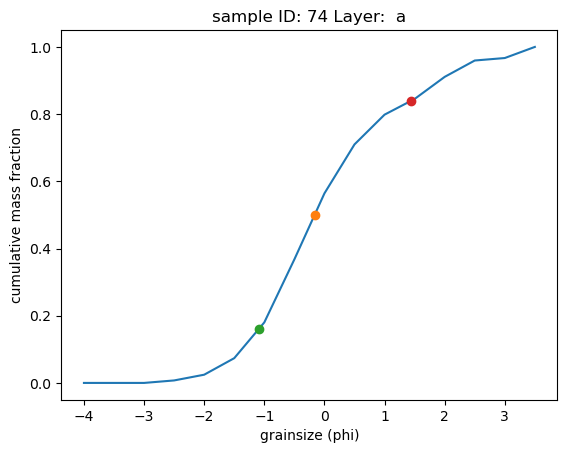

In [4]:
import matplotlib.pyplot as plt

plt.plot(phi,cum_mass_frac)
plt.plot(my_median, 0.5, "o")

if(my_sorting != "out of range"):
    plt.plot(my_phi16, 0.16, "o")
    plt.plot(my_phi84, 0.84, "o")
plt.xlabel ("grainsize (phi)")
plt.ylabel("cumulative mass fraction")
mytitle = "sample ID: " + str(sample_id) + " Layer: " + str(sample_layer)
plt.title(mytitle)
plt.show()